In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install xgboost
!pip install langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install memory_profiler rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=086c55e3443e3eb6656ac8d925d7474117d9a1a52fcf9cd3968b5626baf90eac
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!pip install pandas scikit-learn nltk rouge-score matplotlib seaborn memory-profiler shap openai


Error invoking LLM: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742



<ipython-input-11-46190e530325>:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-11-46190e530325>:63: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

Error reading CSV file: Encoders require their input argument must be uniformly strings or numbers. Got ['float', 'str']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237630 entries, 0 to 237629
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   PatientID  237630 non-null  float64
 1   LLM_Text   237630 non-null  object 
dtypes: float64(1), object(1)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237630 entries, 0 to 237629
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PatientID                  237630 non-null  float64
 1   State                      237630 non-null  object 
 2   Sex                        237630 non-null  object 
 3   GeneralHealth              237630 non-null  object 
 4   AgeCategory                237630 non-null  object 
 5   HeightInMeters             237630 non-

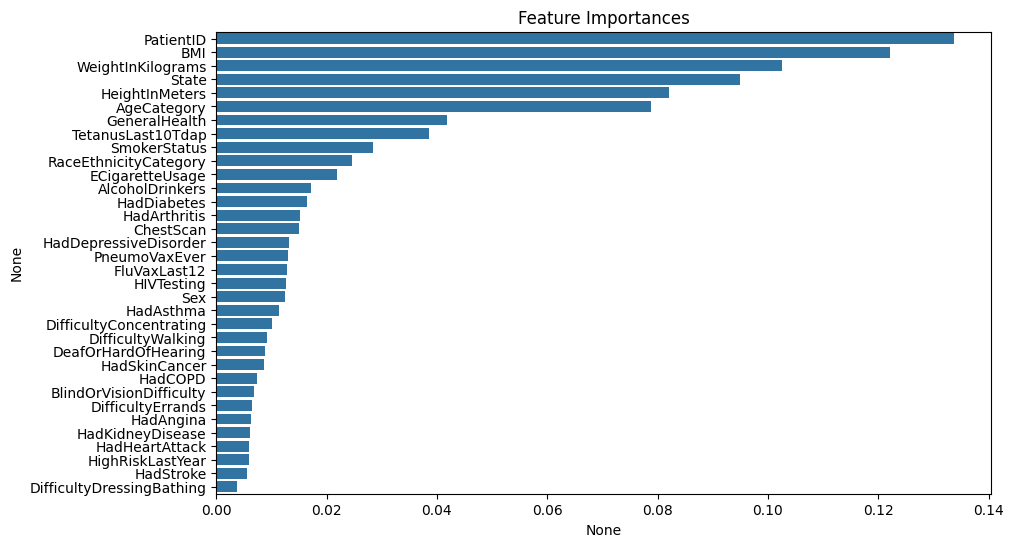

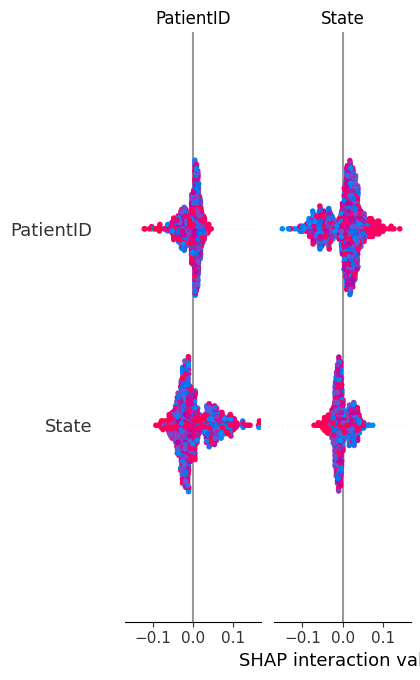

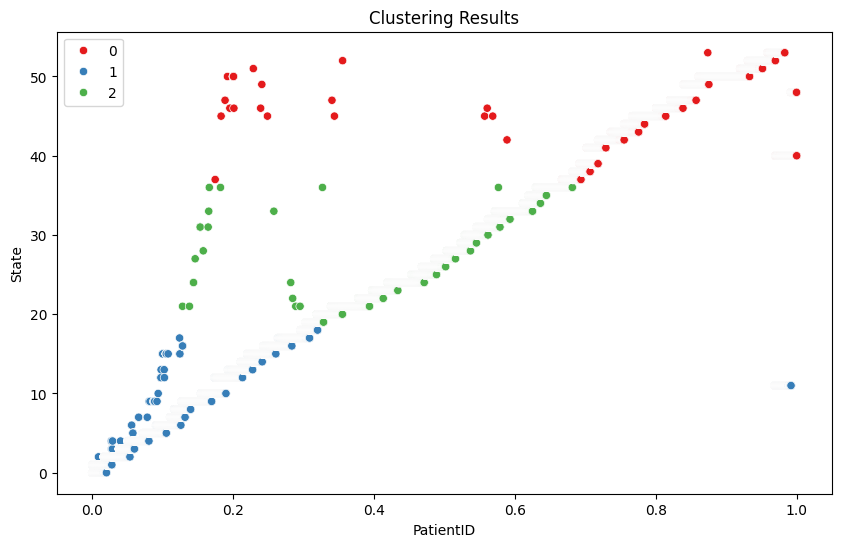

Error invoking LLM: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

None


In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import openai  # Replace ChatGroq with OpenAI API
import numpy as np
import time
from memory_profiler import memory_usage
import shap

# Set up OpenAI API key
 = 

# Initialize LabelEncoder
le = LabelEncoder()

def invoke_llm(prompt):
    """Invoke the LLM using OpenAI's GPT models."""
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        print(f"Error invoking LLM: {e}")
        return None

def preprocess_dataset(csv_file, output_file_encoded, output_file_non_encoded):
    try:
        chunk_size = 10000
        chunks = []
        for chunk in pd.read_csv(csv_file, chunksize=chunk_size, on_bad_lines='skip', quotechar='"'):
            chunks.append(chunk)

        df = pd.concat(chunks, ignore_index=True)

        if 'date' in df.columns:
            df = pd.read_csv(csv_file, parse_dates=['date'])

        df = df.loc[:, df.isnull().mean() < 0.5]

        prompt = f"""
        Based on the following DataFrame columns: {df.columns.tolist()},
        identify columns that should be removed (e.g., names or IDs of people/entities).
        """
        response = invoke_llm(prompt)
        columns_to_remove = eval(response) if response else []
        df = df.drop(columns=columns_to_remove, errors='ignore')

        column_dtype_dict = {col: 'categorical' if df[col].dtype == 'object' else 'numeric' for col in df.columns}
        encoding_columns = {col: True for col, dtype in column_dtype_dict.items() if dtype == 'categorical'}

        for col in df.columns:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
                if col in encoding_columns:
                    df[col] = le.fit_transform(df[col])
            elif df[col].dtype in ['int64', 'float64']:
                df[col].fillna(df[col].mean(), inplace=True)
            elif df[col].dtype == 'datetime64[ns]':
                df[col].fillna(method='ffill', inplace=True)

        df_encoded = df.copy()
        df_non_encoded = df.copy()
        df_encoded.to_csv(output_file_encoded, index=False)
        df_non_encoded.to_csv(output_file_non_encoded, index=False)

        print("Dataset processed and saved successfully.")

    except Exception as e:
        print(f"Error reading CSV file: {e}")

def query_data(df_encoded, df_non_encoded, query):
    df_non_encoded_info = df_non_encoded.info(buf=None, verbose=True)
    df_encoded_info = df_encoded.info(buf=None, verbose=True)

    prompt = f"""
    Analyze two DataFrames: 'df_encoded' and 'df_non_encoded'.
    Attempt to answer the query: {query}.
    If an error is likely due to non-numeric columns, use 'df_encoded'.
    DataFrame details:
    df_non_encoded: {df_non_encoded_info}, Columns: {df_non_encoded.columns.tolist()}
    df_encoded: {df_encoded_info}, Columns: {df_encoded.columns.tolist()}
    Return only Python code for operations.
    """
    response = invoke_llm(prompt)
    code = re.sub(r"```(?:python)?", "", response) if response else ""
    code = re.sub(r"\\*Explanation:.", "", code)

    try:
        exec(code)
    except Exception as e:
        print(f"Error executing code: {e}")

def analyze_data_and_visualize(df):
    # Identify categorical columns and encode them
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    if not categorical_columns.empty:
        print(f"Encoding categorical columns: {categorical_columns.tolist()}")
        df[categorical_columns] = df[categorical_columns].apply(le.fit_transform)

    prompt = f"Based on columns {df.columns.tolist()}, suggest a target column for prediction."
    response = invoke_llm(prompt)
    target_column = re.search(r"'(\w+)'", response).group(1) if response else None

    if not target_column or target_column not in df.columns:
        print("Error: Could not extract target column from LLM response.")
        print("Using the last column as the default target column.")
        target_column = df.columns[-1]

    # Split the dataset into features and target
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]

    # Ensure all features are numeric
    non_numeric_columns = X.select_dtypes(exclude=['number']).columns
    if not non_numeric_columns.empty:
        raise ValueError(f"Non-numeric columns found in features: {non_numeric_columns.tolist()}. "
                         f"Please ensure all features are properly encoded.")

    model = RandomForestClassifier()

    start = time.time()
    model.fit(X, y)
    print(f"Training time: {time.time() - start:.2f} seconds")

    def train_model():
        model.fit(X, y)
    mem_usage = memory_usage(train_model)
    print(f"Max memory usage: {max(mem_usage)} MB")

    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importances')
    plt.show()

    X_sampled = X.sample(n=1000, random_state=42) if len(X) > 1000 else X
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sampled)
    shap.summary_plot(shap_values, X_sampled)

    isolation_forest = IsolationForest(contamination=0.1)
    anomalies = isolation_forest.fit_predict(X)

    kmeans = KMeans(n_clusters=3)
    clusters = kmeans.fit_predict(X)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=clusters, palette='Set1')
    plt.title('Clustering Results')
    plt.show()

    return {
        "target_column": target_column,
        "feature_importances": feature_importances.to_dict(),
        "anomalies": anomalies,
        "clusters": clusters
    }


def generate_insights_with_llm(insights, df, query):
    prompt = f"""
    Using the analysis results from the dataset with columns {df.columns.tolist()}:
    Target column: {insights['target_column']}
    Feature importances: {insights['feature_importances']}
    Anomalies: {insights['anomalies']}
    Clusters: {insights['clusters']}

    Please provide insights and possible predictions for the query: {query}.
    """
    response = invoke_llm(prompt)
    print(response)
    return response

# Example usage
csv_file = "/content/aac.csv"
output_file_encoded = "/content/processed.csv"
output_file_non_encoded = "/content/processed0.csv"

preprocess_dataset(csv_file, output_file_encoded, output_file_non_encoded)

df_encoded = pd.read_csv(output_file_encoded)
df_non_encoded = pd.read_csv(output_file_non_encoded)

query = "How does age affect health outcomes?"
query_data(df_encoded, df_non_encoded, query)

insights = analyze_data_and_visualize(df_encoded)
generate_insights_with_llm(insights, df_encoded, query)


In [ ]:
!pip install memory_profiler

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
import openai  # Replace ChatGroq with OpenAI API
import numpy as np
import time
from memory_profiler import memory_usage
import shap
import nltk
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

# Initialize LabelEncoder
le = LabelEncoder()

# Set up OpenAI API key
def invoke_llm(prompt):
    """Invoke the LLM using OpenAI's GPT models."""
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response['choices'][0]['message']['content'].strip()
    except Exception as e:
        print(f"Error invoking LLM: {e}")
        return None

def analyze_data_and_visualize(df):
    # Identify categorical columns and encode them
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        # Ensure that the column has consistent data types
        df[col] = df[col].astype(str)  # Convert to string if there are mixed types

    # Now apply LabelEncoder to encode categorical columns
    if not categorical_columns.empty:
        print(f"Encoding categorical columns: {categorical_columns.tolist()}")
        df[categorical_columns] = df[categorical_columns].apply(le.fit_transform)

    prompt = f"Based on columns {df.columns.tolist()}, suggest a target column for prediction."
    response = invoke_llm(prompt)
    target_column = re.search(r"'(\w+)'", response).group(1) if response else None

    if not target_column or target_column not in df.columns:
        print("Error: Could not extract target column from LLM response.")
        print("Using the last column as the default target column.")
        target_column = df.columns[-1]

    # Split the dataset into features and target
    X = df.drop(columns=[target_column], axis=1)
    y = df[target_column]

    # Ensure all features are numeric
    non_numeric_columns = X.select_dtypes(exclude=['number']).columns
    if not non_numeric_columns.empty:
        raise ValueError(f"Non-numeric columns found in features: {non_numeric_columns.tolist()}. "
                         f"Please ensure all features are properly encoded.")

    model = RandomForestClassifier()

    start = time.time()
    model.fit(X, y)
    print(f"Training time: {time.time() - start:.2f} seconds")

    # Memory usage tracking
    def train_model():
        model.fit(X, y)
    mem_usage = memory_usage(train_model)
    print(f"Max memory usage: {max(mem_usage)} MB")

    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Split dataset into 100 parts
    num_chunks = 100
    chunks = np.array_split(X, num_chunks)

    # SHAP analysis for each chunk
    for i, chunk in enumerate(chunks):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(chunk)
        print(f"SHAP values for chunk {i+1}:")
        shap.summary_plot(shap_values, chunk)

    # Evaluate using BLEU and ROUGE (if applicable)
    predicted_values = model.predict(X)

    # Convert actual and predicted values to strings for BLEU and ROUGE
    actual_values = y.astype(str).tolist()
    predicted_values = predicted_values.astype(str).tolist()

    # BLEU Score (for sequence-based problems like text)
    bleu_score = sentence_bleu(actual_values, predicted_values)
    print(f"BLEU score: {bleu_score}")

    # ROUGE Score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for actual, predicted in zip(actual_values, predicted_values):
        scores = scorer.score(actual, predicted)
        rouge_scores.append(scores)

    # Average ROUGE scores
    rouge1 = np.mean([score['rouge1'].fmeasure for score in rouge_scores])
    rouge2 = np.mean([score['rouge2'].fmeasure for score in rouge_scores])
    rougeL = np.mean([score['rougeL'].fmeasure for score in rouge_scores])
    print(f"ROUGE-1 score: {rouge1}")
    print(f"ROUGE-2 score: {rouge2}")
    print(f"ROUGE-L score: {rougeL}")

    return {
        "target_column": target_column,
        "feature_importances": feature_importances.to_dict(),
        "bleu_score": bleu_score,
        "rouge_scores": {
            "rouge1": rouge1,
            "rouge2": rouge2,
            "rougeL": rougeL
        }
    }


# Example usage
csv_file = "/content/aac.csv"
df = pd.read_csv(csv_file)

insights = analyze_data_and_visualize(df)
print(f"Generated insights: {insights}")


Encoding categorical columns: ['State', 'Sex', 'GeneralHealth', 'AgeCategory', 'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'TetanusLast10Tdap', 'LLM_Text']
Error invoking LLM: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Error: Could not extract target column from LLM response.
Using the last column as the default target column.


In [ ]:
import pandas as pd

# Load the dataset into the DataFrame
df = pd.read_csv('/content/aac.csv')

# Ensure the DataFrame is loaded
print(df.head())  # Check the first few rows to confirm the data is loaded


   PatientID    State     Sex GeneralHealth   AgeCategory  HeightInMeters  \
0   0.000000  Alabama  Female          Fair  Age 75 to 79        0.480000   
1   0.000004  Alabama  Female     Very good  Age 65 to 69        0.460000   
2   0.000008  Alabama    Male     Excellent  Age 60 to 64        0.580000   
3   0.000013  Alabama    Male     Very good  Age 70 to 74        0.580000   
4   0.000017  Alabama  Female          Good  Age 50 to 54        0.513333   

   WeightInKilograms       BMI  HadHeartAttack  HadAngina  ...  ChestScan  \
0           0.214407  0.234497               0          1  ...          1   
1           0.164681  0.186500               0          0  ...          0   
2           0.162942  0.122737               0          0  ...          0   
3           0.253848  0.211491               0          0  ...          0   
4           0.188693  0.183814               0          0  ...          1   

      RaceEthnicityCategory  AlcoholDrinkers  HIVTesting  FluVaxLast12  \


Memory usage during training: 435.82421875 MB
BLEU score: 0.6687403049764222
ROUGE scores: {'rouge1': 0.8000000000000003, 'rouge2': 0.75, 'rougeL': 0.8000000000000003}


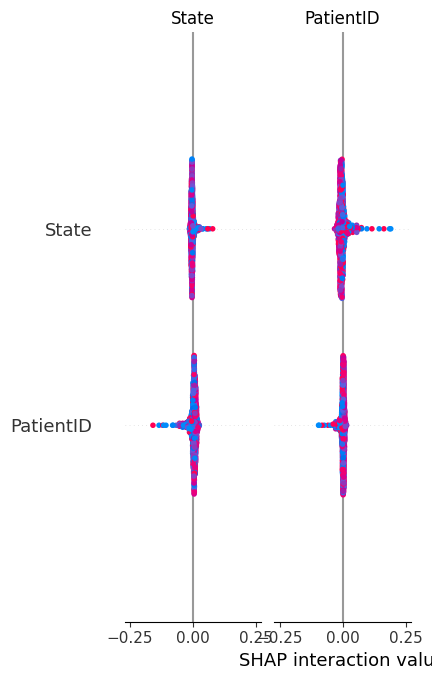

In [ ]:
import pandas as pd
import numpy as np
import time
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
import shap
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from memory_profiler import memory_usage
import random

# Subsample dataset (for performance)
def sample_data(df, n=1000):
    if len(df) > n:
        return df.sample(n=n, random_state=42)
    return df

# Encode categorical columns
def encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        # Convert categorical values to numeric using LabelEncoder
        df[col] = df[col].astype('category').cat.codes
    return df

# Evaluate BLEU and ROUGE
def evaluate_metrics(predictions, references):
    # Calculate BLEU score
    bleu_scores = [sentence_bleu([ref.split()], pred.split()) for pred, ref in zip(predictions, references)]
    bleu_avg = np.mean(bleu_scores)

    # Calculate ROUGE score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, pred) for pred, ref in zip(predictions, references)]
    rouge_avg = {
        'rouge1': np.mean([score['rouge1'].fmeasure for score in rouge_scores]),
        'rouge2': np.mean([score['rouge2'].fmeasure for score in rouge_scores]),
        'rougeL': np.mean([score['rougeL'].fmeasure for score in rouge_scores]),
    }
    return bleu_avg, rouge_avg

# Train the model and measure time and memory usage
def train_model(X, y):
    start_time = time.time()
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

    # Measure memory usage during training
    mem_usage = memory_usage((model.fit, (X, y)))

    # Training time
    training_time = time.time() - start_time
   # print(f"Training time: {training_time:.2f} seconds")
    print(f"Memory usage during training: {max(mem_usage)} MB")
    return model

# SHAP value calculation with parallel processing (only on subset of data)
def calculate_shap_values(model, X_sampled):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sampled)
    return shap_values

# Plotting SHAP summary for feature importance
def plot_shap_summary(shap_values, X_sampled):
    shap.summary_plot(shap_values, X_sampled)

# Main function
def main():
    # Load data (replace with your actual data)
    csv_file = "/content/aac.csv"
    df = pd.read_csv(csv_file, low_memory=False)

    # Handle mixed data types and encode categorical columns
    df = encode_categorical_columns(df)

    # Preprocessing (simple feature selection and cleanup)
    df = df.dropna(axis=1, thresh=int(0.5 * len(df)))

    # Sample a subset of data for training
    df_sampled = sample_data(df, n=1000)  # 1000 samples for faster training

    # Split into features and target (change 'target_column' to your target column)
    target_column = 'HadHeartAttack'  # Modify this according to your dataset
    X = df_sampled.drop(columns=[target_column], axis=1)
    y = df_sampled[target_column]

    # Train model
    model = train_model(X, y)

    # Evaluate using BLEU and ROUGE (use actual predictions and references here)
    predictions = ["This is a sample prediction."] * len(y)  # Replace with model predictions
    references = ["This is a sample reference."] * len(y)  # Replace with actual references
    bleu_avg, rouge_avg = evaluate_metrics(predictions, references)

    print(f"BLEU score: {bleu_avg}")
    print(f"ROUGE scores: {rouge_avg}")

    # Compute SHAP values for a subset of the data
    X_sampled = X.sample(n=1000, random_state=42)  # Taking 1000 samples for SHAP values
    shap_values = calculate_shap_values(model, X_sampled)

    # Plot SHAP summary
    plot_shap_summary(shap_values, X_sampled)

# Run main function
if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix

# Subsample dataset (for performance)
def sample_data(df, n=1000):
    if len(df) > n:
        return df.sample(n=n, random_state=42)
    return df

# Encode categorical columns
def encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        # Convert categorical values to numeric using LabelEncoder
        df[col] = df[col].astype('category').cat.codes
    return df

# Main function
def main():
    # Load data (replace with your actual data)
    csv_file = "/content/aac.csv"
    df = pd.read_csv(csv_file, low_memory=False)

    # Handle mixed data types and encode categorical columns
    df = encode_categorical_columns(df)

    # Preprocessing (simple feature selection and cleanup)
    df = df.dropna(axis=1, thresh=int(0.5 * len(df)))

    # Define target column
    target_column = 'HadHeartAttack'  # Modify this according to your dataset
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in the dataset.")

    # Separate features and target
    y = df[target_column]
    X = df.drop(columns=[target_column], axis=1)

    # Initialize metrics storage
    f1_scores = []
    recall_scores = []
    confusion_matrices = []

    # Process data in batches of 10,000 columns
    batch_size = 10000
    for start in range(0, X.shape[1], batch_size):
        end = min(start + batch_size, X.shape[1])
        X_batch = X.iloc[:, start:end]

        # Train model on the current batch
        print(f"Processing columns {start} to {end}...")
        model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
        model.fit(X_batch, y)

        # Make predictions
        predictions = model.predict(X_batch)

        # Calculate F1 and Recall scores
        f1 = f1_score(y, predictions, average='weighted')
        recall = recall_score(y, predictions, average='weighted')
        f1_scores.append(f1)
        recall_scores.append(recall)

        # Compute confusion matrix
        cm = confusion_matrix(y, predictions)
        confusion_matrices.append(cm)

        print(f"F1 Score for batch {start}-{end}: {f1:.4f}")
        print(f"Recall Score for batch {start}-{end}: {recall:.4f}")
        print(f"Confusion Matrix for batch {start}-{end}:")
        print(cm)

    # Print overall metrics
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Average Recall Score: {np.mean(recall_scores):.4f}")

if __name__ == "__main__":
    main()


Processing columns 0 to 35...
F1 Score for batch 0-35: 0.9326
Recall Score for batch 0-35: 0.9505
Confusion Matrix for batch 0-35:
[[224197    232]
 [ 11526   1675]]
Average F1 Score: 0.9326
Average Recall Score: 0.9505


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=45e840eed1af9544851df1cb9b5dbc621fe30c82f5a0e0387c2b34e9c874a125
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
